In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-data/DIG Historical Data 1_6.csv
/kaggle/input/stock-data/NVL Historical Data 1_6.csv
/kaggle/input/stock-data/DXG Historical Data 1_6.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

2024-06-19 07:28:04.230086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 07:28:04.230201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 07:28:04.366752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/kaggle/input/stock-data/DXG Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[::-1]
df1=df.reset_index()['Price']
df1

0       13401.4
1       13371.1
2       13522.4
3       13159.4
4       14066.9
         ...   
1593    16550.0
1594    16800.0
1595    16850.0
1596    16850.0
1597    16800.0
Name: Price, Length: 1598, dtype: float64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
test_size

480

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)



In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
X_train.shape

(1017, 100, 1)

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0432 - val_loss: 0.0018
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015 - val_loss: 9.5017e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
y_pred.shape

(379, 1)

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
test_mae = np.mean(np.abs(ytest - y_pred))


print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 16165.217875980672
Testing MAPE: 8329514.34079768
Testing MAE: 15829.548233592479


In [17]:
## 13. Dự báo 90 ngày tiếp theo
x_input=test_data[380:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.2543194]
101
1 day input [0.31018797 0.31143763 0.31643627 0.32518389 0.32393423 0.31893559
 0.31268729 0.30144036 0.29644172 0.306439   0.30518934 0.31143763
 0.30518934 0.31143763 0.306439   0.30393968 0.30144036 0.30518934
 0.3001907  0.3001907  0.2939424  0.29644172 0.29519206 0.29269274
 0.29269274 0.29144308 0.29894104 0.30518934 0.30144036 0.30518934
 0.3001907  0.2939424  0.28269547 0.27769683 0.28644444 0.28269547
 0.2876941  0.29269274 0.29769138 0.29519206 0.28519478 0.29019342
 0.28269547 0.27519751 0.26894921 0.28519478 0.28394512 0.28894376
 0.306439   0.2939424  0.3001907  0.31893559 0.32768321 0.32393423
 0.32768321 0.33893014 0.33143218 0.32768321 0.33643082 0.35142674
 0.33143218 0.33268184 0.32893287 0.32518389 0.33518116 0.32143491
 0.31268729 0.32643355 0.29269274 0.27269819 0.24895466 0.22146215
 0.23145943 0.21896283 0.24520568 0.24020704 0.23520841 0.2414567
 0.2414567  0.25895194 0.25645262 0.2539533  0.24645534 0.25145398
 0.25270364 0.25895194 0.25895194 0

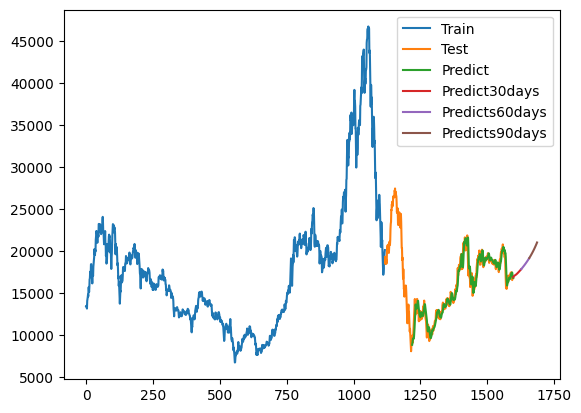

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output[0:30]))
predict_data_index_60 = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output[30:60]))
predict_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output[60:90]))

plt.legend(['Train','Test','Predict','Predict30days', 'Predicts60days', 'Predicts90days'])
plt.savefig('Team4_LSTM_NVL_9_1.png')
plt.show()
